# COMP5046 Assignment 1


# Readme
>Drive needs to be mounted which can be done in Model Implementation part using the code to mount the drive. Otherwise it could be manually mounted. The path needs to be set up or modified in the model while saving and/or loading the models.

>Training the models is not needed if they are just being loaded and used. However, we need to run the cells related to building the models before loading them so as to establish the model's architecture.

>Models are stored at path: gdrive/My Drive/NLP Assignment 1.

>After certain trials, 100 batches was found to be not getting affected by memory crashes. However, it still happened once with 100 batches too. If that happens again, please reduce the number of batches to 50 while making the sample for the input batches. [In sequence model (part 2.3) and evaluation (part 3.2)] 

>The libraries to be imported for the particular segments are listed in the corresponding sections to get a better understanding while avoiding the repetition of imports.

>Word embedding model is run using 100 epochs for finalizing the assignment. A reducing loss can be observed. However, it was required for me to run the model again and again due to mistakes made and debugging them, hence 100 epochs are used. If time allows, a higher epoch value could be used to train the model even further. (Though, it should not be too high to avoid over-fitting).

# 1 - Data Preprocessing

## 1.1. Download Dataset

In [2]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import torch
import pandas as pd

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Setting GPU for computation (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

Training set number: 25000
Testing set number: 25000


## 1.2. Preprocess data

>Case folding: It is done to remove anomalies between occurrences like 'Apple' and 'apple' where the same word could otherwise be considered different if it comes in the starting of the sentence. lower() is used for this purpose.

>Punctuation removal: Regex is used to keep only the alphabets and numbers in the data. The whitespace characters are also kept by adding the '\s' tag. Therefore, all the symbols, phonetic alphabets and special characters are removed.

>Tokenization: NLTK 'punkt' is used to tokenize the words of train and test reviews using word_tokenize from nltk.tokenize library. This gives us all the individual words from the reviews that were separated by whitespace into a list.

>Stopwords removal: all the stopwords have been removed from the data to remove the words that don't provide much semantic values. 'Stopwords' from nltk.corpus has been used to identify and remove such words from the train and test reviews.

>Lemmatization: 'wordnet' lemmatizer is used from nltk.net to convert each word into their lemmas so that words ('run', 'running') having different representations of the same root word could be converted to their root form.

>>Stemming: shortens the words by cropping off their prefixes and suffixes. It is not done here as it sometimes leads to words that are not easily interpretable. Since, lemmatization is used which converts the words to their root forms, stemming is not used.

>Label Encoding: The labels ('pos', 'neg') are encoded ('0', '1') using Label Encoder from sklearn.preprocessing for ease of computation.

In [3]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

#Function using regex to remove punctuations and keep only the letters, numbers and whitespaces
def remove_punctuation_re(x):
    #Keeping only the lower-case letters and symbols in the data
    x = re.sub('[^a-z0-9\s]','',x)
    return x

#Doing case folding first and then applying regex:
reviews_train = [remove_punctuation_re(s.lower()) for s in reviews_train]
reviews_test = [remove_punctuation_re(s.lower()) for s in reviews_test]

#Tokenization
reviews_train = [word_tokenize(s) for s in reviews_train]
reviews_test = [word_tokenize(s) for s in reviews_test]

#Removing stopwords
stop_words = sw.words()
reviews_train_ns=[]
for tokens in reviews_train:
    filtered_sentence = [w for w in tokens if not w in stop_words]
    reviews_train_ns.append(filtered_sentence)
reviews_test_ns=[]
for tokens in reviews_test:
    filtered_sentence = [w for w in tokens if not w in stop_words]
    reviews_test_ns.append(filtered_sentence)

#Lemmatisation
lemmatizer = WordNetLemmatizer()
reviews_train_le = []
for tokens in reviews_train_ns:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    reviews_train_le.append(lemma_sentence)
reviews_test_le = []
for tokens in reviews_test_ns:
    lemma_sentence = [lemmatizer.lemmatize(w) for w in tokens ]
    reviews_test_le.append(lemma_sentence)

#Label Encoding
labels = np.unique(sentiments_train)
lEnc = LabelEncoder()
lEnc.fit(labels)
label_train = lEnc.transform(sentiments_train)
label_test = lEnc.transform(sentiments_test)
numClass = len(labels)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# 2 - Model Implementation

## 2.1. Word Embeddings

>Skipgram model is used for building the word embeddings because it better captures the infrequent words as compared to the CBOW model. CBOW uses averaging the context vectors which makes it hard to interpret the strong associations between the context and target. Hence, skipgram appears more suitable for the cases with infrequent words.

Below are the libraries to be imported for the modelling and for mounting the drive.

In [4]:
from google.colab import drive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import torch.nn as nn
import torch.optim as optim
from random import sample

#Mounting G-drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 2.1.1. Data Preprocessing for Word Embeddings

>Complete dataset is used to create word embeddings so as to capture whole of the vocabulary used in the data. (There could be words used in test set but not in train set.) So, embeddings_train consists of the lemmatized data from both train and test set.

>Unique words are taken out from the dataset for building the word embeddings.
A word dictionary word_dict is also created to refer to each word in the later parts.

>Skipgram-tuples are created from the word_sequence with the window size of 2 (1 context word on each side of the target word).

In [0]:
#Using complete data (train+test) to create embeddings for each word in the data's vocabulary.
embeddings_train = []
for i in reviews_train_le:
  embeddings_train+=i
for i in reviews_test_le:
  embeddings_train+=i


#Making list of unique words and a dictionary to reference each index of unique word in later parts
word_sequence = " ".join(embeddings_train).split()
word_list = " ".join(embeddings_train).split()
word_list = sorted(list(set(word_list)))
#Adding 'P' (in upper case) to the word list to reference padded words.
word_list.append('P')
word_dict = {w: i for i, w in enumerate(word_list)}


#Making skip-grams from the words with window size 2 (1 context-word in each direction of target word).
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]],word_dict[word_sequence[i+1]]]
    for w in context:
        skip_grams.append([target, w])

### 2.1.2. Build Word Embeddings Model

>The hyperparameters set are:

voc_size = len(word_list): outputs from model are the embeddings of the different words in our vocabulary.

learning_rate = 0.005: 0.001 was converging very slowly as the skipgram model takes too long to compute, while 0.01 was jumping around a particular loss value being unable to reduce it (the loss was almost stagnant). I also tried the learning rate of 0.1, in which model gave unstable loss. Hence, 0.005 is taken.

embedding_size = 100: The number of unique words is of the order of 168k (168 thousands). Hence, 100 features are used to create their embeddings. 

>Random batches are made to be input to the model from the skip-gram tuples.

>CrossEntropy Loss and Adam optimizer are used to create the loss and optimize while training the model where CrossEntropy loss calculates the loss of the classification problem and Adam optimizer tries to optimize it faster while considering the history as well.

In [0]:
#Hyperparameters
voc_size = len(word_list)
learning_rate = 0.01
embedding_size = 100

def prepare_batch(data): #Function to randomly prepare batch from the data we have (to save computational time)
    random_inputs = []
    random_labels = []
    for i in range(len(data)):
        input_temp = [0]*voc_size
        input_temp[data[i][0]] = 1
        random_inputs.append(input_temp)  # target
        random_labels.append(data[i][1])  # context word
    return np.array(random_inputs), np.array(random_labels)

class SkipGram(nn.Module):
    def __init__(self):
        super(SkipGram, self).__init__()
        self.linear1 = nn.Linear(voc_size, embedding_size, bias=False)
        self.linear2 = nn.Linear(embedding_size, voc_size, bias=False)
    def forward(self, x):
        hidden = self.linear1(x)
        out = self.linear2(hidden)
        return out

skip_gram_model = SkipGram()
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(skip_gram_model.parameters(), lr=learning_rate)

### 2.1.3. Train Word Embeddings Model

>The input for the model is created by first taking a subset of 1000 tuples from the skip-gram tuples by using sample() from random library. 
This subset is then used to prepare batches to be fed to the model. The batches are generated by taking random tuples from the subset and one-hot encoding them.

>The loss is displayed after every 10 epochs and model is trained upto 100 epochs. The number of epochs was decided upon by considering the computation time being required by the model. After 100 epochs, model shows some convergence. Hence, 100 is used as the optimal value.

>trained_embeddings consist of the final embeddings resulted from the model.

In [11]:
for epoch in range(100):
    i = sample(skip_grams,1000)
    inputs,labels = prepare_batch(i)
    inputs_torch = torch.from_numpy(inputs).float()
    labels_torch = torch.from_numpy(labels)

    optimiser.zero_grad()    
    outputs = skip_gram_model(inputs_torch)

    loss = criterion(outputs, labels_torch)
    loss.backward()
    optimiser.step()
    
    if epoch%10==9:
      print('Epoch: %d, loss: %f' %(epoch + 1, loss))

weight1 = skip_gram_model.linear1.weight
trained_embeddings = weight1.detach().T.numpy()

Epoch: 10, loss: 12.021664
Epoch: 20, loss: 11.797174
Epoch: 30, loss: 10.846331
Epoch: 40, loss: 10.133338
Epoch: 50, loss: 9.775879
Epoch: 60, loss: 9.461576
Epoch: 70, loss: 9.503631
Epoch: 80, loss: 9.483437
Epoch: 90, loss: 9.309270
Epoch: 100, loss: 9.358898


### 2.1.4. Save Word Embeddings Model

In [12]:
torch.save(skip_gram_model, "gdrive/My Drive/NLP Assignment 1/word_embeddings.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SkipGram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.1.5. Load Word Embeddings Model

In [0]:
word_emb_model = torch.load("gdrive/My Drive/NLP Assignment 1/word_embeddings.pt")
weight1 = word_emb_model.linear1.weight
trained_embeddings = weight1.detach().T.numpy()

## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

>Each character was stripped from the tokenized words to obtain unique characters (set(character_array)). 

>A character dictionary is created to index the distinct characters for the purpose of one-hot encoding. A padding character is also appended to the list of unique characters so as to be included in the character dictionary.

>Before one-hot encoding each word is padded by extra characters to make them of the same length as the length of the longest word in the word_list (set of unique words)

>The target labels are also mapped by the make_batch function along with the padded one-hot encoded vectors of the input.

In [0]:
from sklearn.metrics import accuracy_score


#Building character dictionary and enumerating characters
char_arr=[]
for wordtoken in word_list:
  for char in wordtoken:
    char_arr.append(char)
char_dic = {n: i for i, n in enumerate(sorted(list(set(char_arr))))}
input_data = [char_dic[n] for n in char_dic]


#Setting maximum word length to use for padding the words having less number of characters
max_word_length = len(max(word_list, key = len))


#Function to add padding
def add_paddings(word):
    diff = max_word_length - len(word)
    for x in range(diff):
        word += "P"
    return word


#Function to make 'one-hot encoded' input batches from data of 'padded' words. It also maps the target to the corresponding word embedding obtained from previous skip-gram model.
def make_batch(seq_data):
  input_batch=[]
  target_batch=[]
  for seq in seq_data:
    input_word = add_paddings(seq)
    input_data = [char_dic[n] for n in input_word]
    transformed_word = np.eye(len(char_dic))[input_data]
    input_batch.append(transformed_word)
    target_data = trained_embeddings[word_dict[seq]]
    target_batch.append(target_data)
  return input_batch, target_batch

### 2.2.2. Build Character Embeddings Model

>The hyperparameters are:

n_input = len(char_dic): identifying the representation of each character as one-hot vector of 37 length (includes the Padding too).

n_hidden = embedding_size/2 : because the embedding shape of the model is to be made similar to the output of word embeddings model. Hence, we make use of the same embedding_size given to the word embeddings model. The Bi-LSTM model outputs n_hidden*2 dimensions, so it is halved here. (*This also acts as a limitation, where the value of embedding_size should be an even number.)

n_step: max_word_length: The model takes one word at a time character-by-character. Each word is represented by padded characters equal to the length of maximum word length.

>The number of classes in the model is taken as the vocabulary size (number of unique words in the data). 

>Another linear layer is applied to convert the data into the desired format.

>Loss is computed using MSE and optimized using the Adam optimizer.

>Dropout of 0.2 is also used to induce 

In [15]:
n_input = len(char_dic) #Features of the 1-hot encoded characters = length of character dictionary.
n_hidden = int(embedding_size/2) #To make it the same dimension as word-embeddings
total_epoch = 500
learning_rate = 0.005
n_step = max_word_length

#n_class = voc_size     =>  Number of classes = vocabulary size = Number of unique words in the vocabulary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.2)
        self.linear = nn.Linear((n_hidden*2),voc_size)
        self.linear1 = nn.Linear(voc_size,(n_hidden*2))
    def forward(self, sentence):
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        z1 = self.linear1(z)
        return z1,hidden_out

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


###2.2.3. Train Character Embeddings Model

>The input for the model is created by first taking a subset of 100 words from the word_list by using sample() from random library. This subset is then used to prepare batches to be fed to the model. The sub-set of the words taken for input is padded and one-hot encoded before feeding it to the model.

>The word embeddings obtained in the previous word embedding Skipgram model are set as the target batch for calculating the loss. The embeddings output from the Bi-LSTM model are compared with the Skipgram's word-embeddings to calculate loss and thus train the model by trying to minimize the loss.

>The loss is displayed after every 10 epochs and model is trained upto total_epoch set earlier as 500.

>The weights from the last linear layer are extracted to obtain the character-based word embeddings for the data.

In [16]:
for epoch in range(total_epoch):  
    
    word_list_batched = sample(word_list,100)
    char_emb_input, char_emb_target = make_batch(word_list_batched)
    input_batch_torch = torch.from_numpy(np.array(char_emb_input)).float()
    target_batch_torch = torch.from_numpy(np.array(char_emb_target))
    
    # Set the flag to training
    net.train()
    
    outputs,_ = net(input_batch_torch) 
    loss = criterion(outputs, target_batch_torch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Setting the flag to evaluation (therefore turning off the dropout)
    net.eval()
    outputs,_ = net(input_batch_torch) 
    
    # Evaluation loss and accuracy calculation
    loss = criterion(outputs, target_batch_torch)
    if epoch % 10 == 9: 
        print('Epoch: %d, loss: %f' %(epoch + 1, loss.item()))
    #print(epoch, loss.item())
print('Finished Training')

Epoch: 10, loss: 168.304306
Epoch: 20, loss: 2.434288
Epoch: 30, loss: 1.956153
Epoch: 40, loss: 0.598500
Epoch: 50, loss: 0.305499
Epoch: 60, loss: 0.098191
Epoch: 70, loss: 0.081538
Epoch: 80, loss: 0.048041
Epoch: 90, loss: 0.035577
Epoch: 100, loss: 0.023863
Epoch: 110, loss: 0.014592
Epoch: 120, loss: 0.010591
Epoch: 130, loss: 0.008607
Epoch: 140, loss: 0.007489
Epoch: 150, loss: 0.011681
Epoch: 160, loss: 0.008625
Epoch: 170, loss: 0.009327
Epoch: 180, loss: 0.007748
Epoch: 190, loss: 0.008110
Epoch: 200, loss: 0.007973
Epoch: 210, loss: 0.006469
Epoch: 220, loss: 0.004910
Epoch: 230, loss: 0.006881
Epoch: 240, loss: 0.005288
Epoch: 250, loss: 0.005621
Epoch: 260, loss: 0.006715
Epoch: 270, loss: 0.003636
Epoch: 280, loss: 0.005267
Epoch: 290, loss: 0.005696
Epoch: 300, loss: 0.004913
Epoch: 310, loss: 0.005531
Epoch: 320, loss: 0.005563
Epoch: 330, loss: 0.003791
Epoch: 340, loss: 0.005074
Epoch: 350, loss: 0.004087
Epoch: 360, loss: 0.003252
Epoch: 370, loss: 0.005300
Epoch: 3

### 2.2.4 Save Character Embeddings Model

In [17]:
torch.save(net, "gdrive/My Drive/NLP Assignment 1/character_word_embeddings.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.2.5. Load Character Embeddings Model

In [0]:
char_emb_model = torch.load("gdrive/My Drive/NLP Assignment 1/character_word_embeddings.pt")

## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

>The embeddings are captured from the loaded word-embeddings model and the character-based word embeddings model.

>Both the embeddings are concatenated. So, this gives us final embeddings of the shape (embedding_size*2) where embedding_size is the number of features defined at the time of word embeddings.

In [0]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


weight1 = word_emb_model.linear1.weight
w2v_embeddings = weight1.detach().T.numpy()

weight2 = char_emb_model.linear1.weight
c2v_embeddings = weight2.detach().T.numpy()

embeddings= np.concatenate((w2v_embeddings,c2v_embeddings),1) #Assuming the order of w2v_embeddings and c2v_embeddings is same.


#Padding the input reviews to match the sentence with the maximum length
max_sent_length = len(max(reviews_train_le, key = len)) #Limit of adding_paddings set to the max_sentence_length of the train_data.
def sent_paddings(sent):
    diff = max_sent_length - len(sent)
    for x in range(diff):
        sent += "P"
    return sent


reviews_data = reviews_train_le+reviews_test_le
labels_data=label_train.tolist()+label_test.tolist()


#Function to get the padded data and its corresponding labels for the purpose of inputting to the model
def sent_batch(seq_data):
  input_data=[]
  input_sent = [sent_paddings(sent) for sent in seq_data]
  for i in input_sent:
    input_data.append([embeddings[word_dict[word]] for word in i])
  target_data = [labels_data[reviews_data.index(sent)] for sent in seq_data]
  return input_data, target_data

### 2.3.2. Build Sequence Model

>The hyper-parameters are:

Total_epoch = 1000. To save some computational time, 1000 has been set as the parameter.

Learning rate = 0.005: At 1000 epochs, it gave better results than 0.01 and 0.001. (Although 0.001 seemed to work out as well if number of epochs were more).

n_step = max_sent_length: At each time step, we are passing one review. The reviews have been padded to the length of the longest review. Hence, n_step is equal to the padded length of each review (denoted by max_sent_length).

n_input = embeddings.shape[1]. This is the number of features contained by the concatenated embeddings, which is now embeddings_size*2 (=200 here).

n_class = numClass. The output of the model is to predict either class from the given labels ('pos', 'neg'). Hence, n-class = number of the classes.

n_hidden = While taking bigger batch size (of 500), memory was crashing. After some random hit-and-trial, 128 was found to be sending least-sized data. Hence, taken as 128.

>NLL Loss is calculated and Adam optimizer is used to backpropagate and minimize the loss.

In [56]:
#Hyperparameters
learning_rate = 0.005
total_epoch = 1000
n_input = embeddings.shape[1]
n_hidden = 128
n_class = numClass
#n_step = max_sent_length = length of each review after padding



class SeqNet(nn.Module):
    def __init__(self):
        super(SeqNet, self).__init__()
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first =True,bidirectional=True, dropout=0.2)
        self.linear = nn.Linear(n_hidden*2,n_class)

    def forward(self, sentence):
        
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        log_output = F.log_softmax(z, dim=1)
        return log_output,hidden_out

# Move the model to GPU
net2 = SeqNet().to(device)
# Loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(net2.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### 2.3.3. Train Sequence Model

>A subset of 100 reviews from the train-dataset is taken. The reviews are padded and the words in the reviews are mapped to their embeddings before being fed to the model.

>The labels associated with each review are taken as the target batch for the model to calculate the loss. 

>The loss is displayed after every 10 epochs and model is trained upto total_epoch set earlier as 1000.

>Outputs from the log_softmax layer are used to predict the labels and thereby calculating accuracy score.

In [57]:
for epoch in range(total_epoch):

    sent_list_batched = sample(reviews_train_le,100)
    seq_train_input, seq_train_target = sent_batch(sent_list_batched)
    input_batch_torch = torch.from_numpy(np.array(seq_train_input)).float().to(device)
    target_batch_torch = torch.from_numpy(np.array(seq_train_target)).view(-1).to(device)

    # Flag set to training
    net2.train()
    
    outputs,_ = net2(input_batch_torch) 
    loss = criterion(outputs, target_batch_torch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Flag set to evaluation
    net2.eval()
    outputs,_ = net2(input_batch_torch) 
    
    # Evaluation loss and accuracy calculation
    loss = criterion(outputs, target_batch_torch)
    _, predicted = torch.max(outputs, 1)
    acc= accuracy_score(predicted.cpu().numpy(),target_batch_torch.cpu().numpy())

    if epoch%10==9:
      print('Epoch: %d, loss: %.5f, train_acc: %.2f' %(epoch + 1, loss.item(), acc))

print('Finished Training')

Epoch: 10, loss: 0.66929, train_acc: 0.60
Epoch: 20, loss: 0.69807, train_acc: 0.39
Epoch: 30, loss: 0.68891, train_acc: 0.57
Epoch: 40, loss: 0.69077, train_acc: 0.61
Epoch: 50, loss: 0.69276, train_acc: 0.50
Epoch: 60, loss: 0.68599, train_acc: 0.58
Epoch: 70, loss: 0.69116, train_acc: 0.49
Epoch: 80, loss: 0.69640, train_acc: 0.45
Epoch: 90, loss: 0.69149, train_acc: 0.51
Epoch: 100, loss: 0.68667, train_acc: 0.54
Epoch: 110, loss: 0.69112, train_acc: 0.49
Epoch: 120, loss: 0.68592, train_acc: 0.57
Epoch: 130, loss: 0.69437, train_acc: 0.48
Epoch: 140, loss: 0.69031, train_acc: 0.53
Epoch: 150, loss: 0.68679, train_acc: 0.58
Epoch: 160, loss: 0.68759, train_acc: 0.55
Epoch: 170, loss: 0.70409, train_acc: 0.43
Epoch: 180, loss: 0.68486, train_acc: 0.55
Epoch: 190, loss: 0.69003, train_acc: 0.55
Epoch: 200, loss: 0.67878, train_acc: 0.56
Epoch: 210, loss: 0.69326, train_acc: 0.54
Epoch: 220, loss: 0.68033, train_acc: 0.54
Epoch: 230, loss: 0.69339, train_acc: 0.51
Epoch: 240, loss: 0.

### 2.3.4. Save Sequence Model

In [58]:
torch.save(net2, "gdrive/My Drive/NLP Assignment 1/sequence_model.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SeqNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### 2.3.5. Load Sequence Model

In [0]:
seq_model = torch.load("gdrive/My Drive/NLP Assignment 1/sequence_model.pt")

# 3 - Evaluation


## 3.1. Performance Evaluation

>The sequence model trained in previous section is run using the test dataset to obtain the classification report.

>The test inputs are randomly sampled to be a subset of 100 reviews from the lemmatized review data, and the embeddings are mapped for each of the word from the review. 

>The target labels are also looked up for the corresponding reviews and set as the target batch.

>Classification report is generated using the test-labels as true value and predicted labels from the test-inputs as predicted value. sklearn.metrics are used for getting the metrics like the classification report and f1-score.

In [60]:
from sklearn.metrics import classification_report

sent_list_batched_test = sample(reviews_test_le,100)
max_sent_length = len(max(reviews_test_le, key = len))  #Setting max_sent_length from test data for paddings
seq_test_input, seq_test_target = sent_batch(sent_list_batched_test)
test_input_batch_torch = torch.from_numpy(np.array(seq_test_input)).float().to(device)
test_target_batch_torch = torch.from_numpy(np.array(seq_test_target)).view(-1).to(device)

seq_model.eval()
outputs,_ = seq_model(test_input_batch_torch) 
_,predicted = torch.max(outputs, 1)

print(classification_report(test_target_batch_torch.cpu(),predicted.cpu().numpy()))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62        50
           1       0.62      0.66      0.64        50

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.63      0.63      0.63       100



## 3.2. Hyperparameter Testing

>A list is created for learning rates of 0.001, 0.005 and 0.01.

>A random sample of 100 reviews (due to crashing memory problem) is taken up in each epoch to generate the input batches. The input batch is padded according to the max_sent_length which has been modified here to be equal to the maximum length of review in the train set and each word is mapped to the concatenated embeddings of that word. The target labels are also looked up for the corresponding reviews and set as the target batch. 
>>The similar has been done for the test inputs and labels as well to calculate the f1-scores in the evaluation flag.

>Two list of lists are created containing epochs values and f1-scores for each run over the different learning rates.

>f1-scores are calculating by averaging the two f1-scores obtained for the two labels.

>Also, after each run of the model for a particular learning rate for 500 epochs, classification report of the model has also been printed corresponding to that particular epoch.

>Three graphs corresponding to each learning rate are thereafter plotted from the list of lists created for epochs and f1-score, namely x_epochs and y_f1 using matplotlib.pyplot.

In [76]:
from sklearn.metrics import f1_score

learning_rates = [0.01,0.005,0.001]

x_epochs = [[]]
y_f1 = [[]]

for rate in learning_rates:
  optimizer = optim.Adam(net2.parameters(), lr=rate)
  print('\n \n \n \n \n For learning rate:',rate)
  x=[]
  y=[]
  for epoch in range(500):

    sent_list_batched_train = sample(reviews_train_le,100)
    max_sent_length = len(max(reviews_train_le, key = len)) #Setting max_sent_length from train data for paddings
    seq_train_input, seq_train_target = sent_batch(sent_list_batched_train)
    train_input_batch_torch = torch.from_numpy(np.array(seq_train_input)).float().to(device)
    train_target_batch_torch = torch.from_numpy(np.array(seq_train_target)).view(-1).to(device)

    sent_list_batched_test = sample(reviews_test_le,100)
    max_sent_length = len(max(reviews_test_le, key = len)) #Setting max_sent_length from test data for paddings
    seq_test_input, seq_test_target = sent_batch(sent_list_batched_test)
    test_input_batch_torch = torch.from_numpy(np.array(seq_test_input)).to(device)
    test_target_batch_torch = torch.from_numpy(np.array(seq_test_target)).view(-1).to(device)

    #Flag set to train
    seq_model.train()

    outputs,_ = seq_model(train_input_batch_torch) 
    loss = criterion(outputs, train_target_batch_torch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #Setting flag to evaluation and calculating the prediction performance on test set as well
    seq_model.eval()
    outputs,_ = seq_model(test_input_batch_torch) 
    loss = criterion(outputs, test_target_batch_torch)   
    _, predicted = torch.max(outputs, 1)
    f1_pos = f1_score(test_target_batch_torch.cpu(),predicted.cpu().numpy(),pos_label=0)
    f1_neg = f1_score(test_target_batch_torch.cpu(),predicted.cpu().numpy(),pos_label=1)
    f1_epoch = (f1_pos+f1_neg)/2

    if epoch%50==49:
      print(epoch+1,loss.item(),f1_epoch)

    if epoch%20==19:
      x.append(epoch)
      y.append(f1_epoch)  
  
  print("For Learning rate =", rate, '\n', classification_report(test_target_batch_torch.cpu(),predicted.cpu().numpy()))
  x_epochs.append(x)
  y_f1.append(y)
print("Finish")


 
 
 
 
 For learning rate: 0.01
50 0.5800663232803345 0.6892230576441103
100 0.5514218807220459 0.6798719487795117
150 0.49780726432800293 0.7796474358974359
200 0.6033650040626526 0.7033248081841432
250 0.5523039102554321 0.6767676767676768
300 0.673504114151001 0.6269785260610948
350 0.636631190776825 0.6328029375764994
400 0.6148430705070496 0.6347402597402597
450 0.5190352201461792 0.7297567811029926
500 0.5575493574142456 0.7348021215830273
For Learning rate = 0.01 
               precision    recall  f1-score   support

           0       0.71      0.68      0.70        44
           1       0.76      0.79      0.77        56

    accuracy                           0.74       100
   macro avg       0.74      0.73      0.73       100
weighted avg       0.74      0.74      0.74       100


 
 
 
 
 For learning rate: 0.005
50 0.5260639786720276 0.7777777777777778
100 0.5821051001548767 0.7159090909090908
150 0.5475946664810181 0.7266929851199515
200 0.48272669315338135 0.79991996

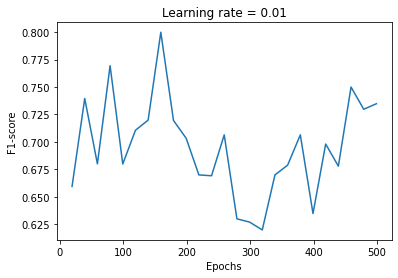

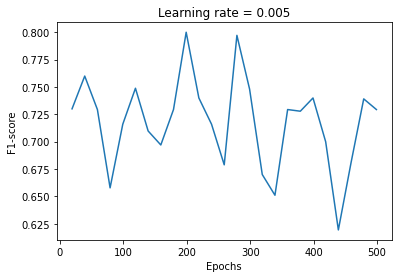

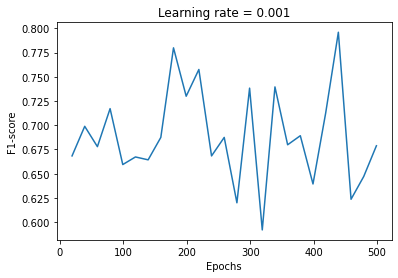

In [77]:
import matplotlib.pyplot as plt

plt.title("Learning rate = 0.01")
plt.plot(x_epochs[1], y_f1[1])
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.show()

plt.title("Learning rate = 0.005")
plt.plot(x_epochs[2], y_f1[2])
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.show()

plt.title("Learning rate = 0.001")
plt.plot(x_epochs[3], y_f1[3])
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.show()

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [0]:
# If you used OOP style, use this section